# LSTM Neural Network
This script has the objective of converting output of the log filter (positions) into the machine learning model using keras.

In [142]:
# Essential imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# LSTM library
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# File Management
import json

# Debug
from datetime import datetime
import time

First let's define the Hyper Parameters and global variables used on the algorithm.

In [143]:
PAST_TIME_STEPS = 60 # Number of past steps that will be stored on the memory

# LABEL_COLUMN = 0 # Column on the object returned by the filtered log
# FEATURE_COLUMNS_RANGE = (0,0)

TRAINING_PATH = "./training_model/csv_with_labels(full).csv"
TRAINING_START_ROW = 0 # default 0
TRAINING_END_ROW = 2000 # default -1

TEST_PATH = "./training_model/csv_with_labels(full).csv"
TEST_START_ROW = 2000 # default 0
TEST_END_ROW = 3000 # default -1

# labels definition
LABELS = ["Short Pass", "Long Pass", "Goal Shot"] 
# TODO: Complete with all labels
# OBS.: These labels will be in the matrix as index values (0..N-1),
# where N is the number of labels
N_NEURONS_LSTM = 50

Here are some functions that will be used on the code. These functions don't have initial configuration because it'll depend how the log filter will be made.

In [144]:
def get_filtered_data(path="", starting_row=0, ending_row=-1):
    """Given a path to a csv file, returns the timestamp and the matrix """

    training_csv = pd.read_csv(path, header=None).values
    timestamps = training_csv[starting_row:ending_row,0]
    matrix = training_csv[starting_row:ending_row, 1:]

    return timestamps, matrix


Get the data and plot the graph

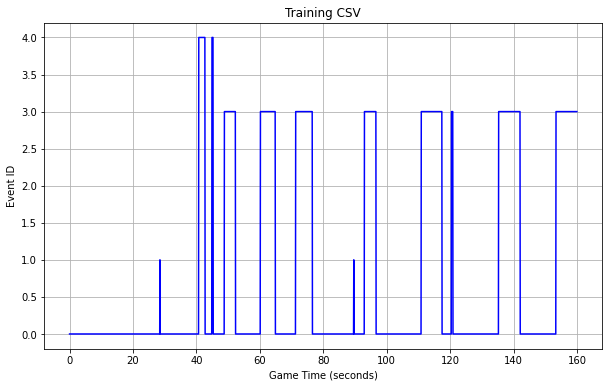

In [145]:
timestamps_training, positions_training = get_filtered_data(path=TRAINING_PATH, starting_row=TRAINING_START_ROW, ending_row=TRAINING_END_ROW)

plt.figure(figsize=(10,6))
plt.plot(timestamps_training, positions_training[:,-1] ,color='blue')
plt.title('Training CSV')
plt.xlabel('Game Time (seconds)')
plt.ylabel('Event ID')
plt.grid()
plt.show()


Now it's needed to get and proccess data accordingly

In [146]:
n_examples = len(positions_training)

n_features = positions_training.shape[1] - 1


# Applying normalization
scaler = MinMaxScaler(feature_range=(0,1)) # Apply values to [0, 1]
positions_training_scaled = scaler.fit_transform(positions_training)

# print(f"{positions_training = }")
# print(f"{positions_training_scaled = }")

# Convert training array to the right shape
features_set = []
labels = []

for i in range(PAST_TIME_STEPS, n_examples):
    features_set.append(positions_training_scaled[i-PAST_TIME_STEPS:i, 0:n_features]) # previous N records
    labels.append(positions_training_scaled[i, -1])

# Converting to numpy arrays
features_set, labels = np.array(features_set), np.array(labels)
# print(features_set)

# Converting to the LSTM format where the dimensions are:
# - number of records
# - number of time steps (past steps)
# - number of indicators/features.
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], features_set.shape[2]))
print(f"{features_set.shape = }")

features_set.shape = (1940, 60, 69)


With the data loaded and formatted, now it's time to create the model itself.

In [147]:
# Model initialization
model = Sequential()

# Adding LSTM layer
# a funcao "add" literalmente adiciona um novo layer, que no nosso caso, sera um LSTM

# The fist LSTM parameter is the number of neurons on the node
# The second one is basically true, because we'll add more layers to the model
# The last one is a shape indicating the number of time steps and the number of indicators
model.add(LSTM(units=N_NEURONS_LSTM, return_sequences=True, input_shape=(features_set.shape[1], features_set.shape[2])))

# Adding Dropout layer (avoids over-fitting)
model.add(Dropout(0.2))

# Adding three more LSTM and Dropout layers
model.add(LSTM(units=N_NEURONS_LSTM, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=N_NEURONS_LSTM, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=N_NEURONS_LSTM))
model.add(Dropout(0.2))

# Adding Dense Layer (ending layer...?)
# 1 unit beause we want to predict
model.add(Dense(units = n_features + 1))

# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')


Training the model

In [148]:
# Training the model
# epochs --> number of iteractions probably
model.fit(features_set, labels, epochs = 10, batch_size = 32)

Epoch 1/50


2022-04-23 16:29:08.075547: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 32126400 exceeds 10% of free system memory.


61/61 [==============================] - 36s 283ms/step - loss: 0.1181
Epoch 2/50
61/61 [==============================] - 21s 341ms/step - loss: 0.1085
Epoch 3/50
25/61 [===========>..................] - ETA: 12s - loss: 0.1063

KeyboardInterrupt: 

Plotting our test model

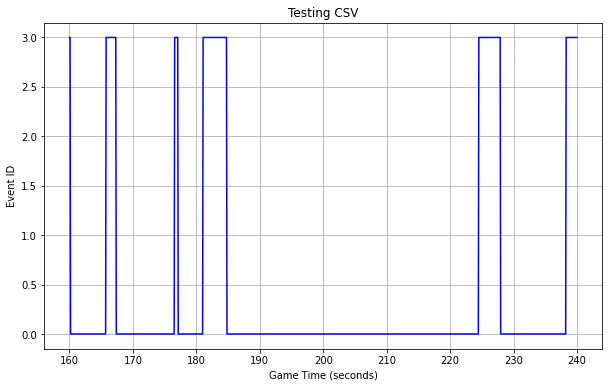

In [ ]:
timestamps_testing, positions_testing = get_filtered_data(path=TEST_PATH, starting_row=TEST_START_ROW, ending_row=TEST_END_ROW)

plt.figure(figsize=(10,6))
plt.plot(timestamps_testing, positions_testing[:,-1] ,color='blue')
plt.title('Testing CSV')
plt.xlabel('Game Time (seconds)')
plt.ylabel('Event ID')
plt.grid()
plt.show()


Testing our model

In [ ]:
# Reshaping the testing
positions_testing_scaled = scaler.transform(positions_testing)
n_tests = len(positions_testing)

# Add Past time
test_features = []
for i in range(PAST_TIME_STEPS, n_tests): 
    test_features.append(positions_testing_scaled[i-PAST_TIME_STEPS:i, 0:n_features])


# Convert to the LSTM format
test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], test_features.shape[2]))

print(f"{test_features.shape = }")


test_features.shape = (998, 2, 69)


Making Predictions

In [ ]:
predictions = model.predict(test_features)
print(f"{predictions.shape = }")
print(f"{test_features.shape = }")
print(f"{n_features = }")

# predictions_dataset_like = np.zeros(shape=(len(predictions), n_features))
# predictions_dataset_like[:,0] = predictions[:,0]
# # inverse transform and then select the right field
# predictions = scaler.inverse_transform(predictions_dataset_like)[:,0]

predictions = scaler.inverse_transform(predictions) # reverse the scale
print(f"{predictions.shape = }")
print(f"{test_features.shape = }")
print(f"{n_features = }")



predictions.shape = (998, 70)
test_features.shape = (998, 2, 69)
n_features = 69
predictions.shape = (998, 70)
test_features.shape = (998, 2, 69)
n_features = 69


Plot results

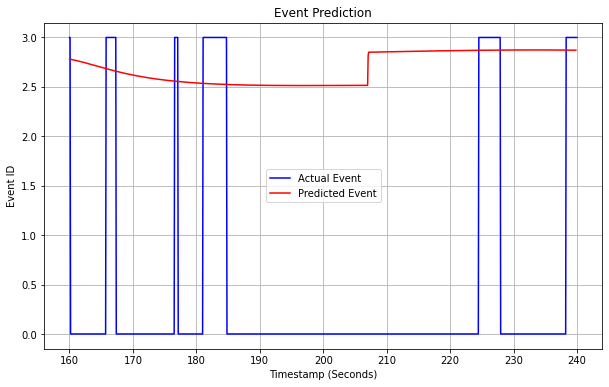

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(timestamps_testing, positions_testing[:,-1], color='blue', label='Actual Event')
plt.plot(timestamps_testing[:-PAST_TIME_STEPS], predictions[:,-1] , color='red', label='Predicted Event')
plt.title('Event Prediction')
plt.xlabel('Timestamp (Seconds)')
plt.ylabel('Event ID')
plt.legend()
plt.grid()
plt.show()